# ** DIscBIO: a user-friendly pipeline for biomarker discovery in single-cell transcriptomics**
#                            PART 1

The pipeline consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![DIsccBIO](DiscBIO.png)

## Required Packages

In [1]:
library(DIscBIO)
library(partykit)
library(enrichR)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

## Loading dataset

The "CTCdataset" dataset consisting of single migratory circulating tumor cells (CTCs) collected from patients with breast cancer. Data are available in the GEO database with accession number GSE51827.The dataset should be formatted in a data frame where columns refer to samples and rows refer to genes. We provide here the possibility to load the dataset either as ".csv" or ".rda" extensions.

In [2]:
FileName<-"CTCdataset"        # Name of the dataset
#CSV=TRUE                     # If the dataset has ".csv", the user shoud set CSV to TRUE
CSV=FALSE                     # If the dataset has ".rda", the user shoud set CSV to FALSE

if (CSV==TRUE){
    DataSet <- read.csv(file = paste0(FileName,".csv"), sep = ",",header=T)
    rownames(DataSet)<-DataSet[,1]
    DataSet<-DataSet[,-1]
} else{
    load(paste0(FileName,".rda"))
    DataSet<-get(FileName)
}
cat(paste0("The ", FileName," contains:","\n","Genes: ",length(DataSet[,1]),"\n","cells: ",length(DataSet[1,]),"\n"))

The CTCdataset contains:
Genes: 13181
cells: 1462


In [3]:
sc<- DISCBIO(DataSet)       # The DISCBIO class is the central object storing all information generated throughout the pipeline 

## 1. Data Pre-processing

Prior to applying data analysis methods, it is standard to pre-process the raw read counts resulted from the sequencing. The preprocessing approach depends on the existence or absence of ERCC spike-ins. In both cases, it includes normalization of read counts and gene filtering. 

#### Normalization of read counts
To account for RNA composition and sequencing depth among samples (single-cells), the normalization method “median of ratios” is used. This method takes the ratio of the gene instantaneous median to the total counts for all genes in that cell (column median). The gene instantaneous median is the product of multiplying the median of the total counts across all cells (row median) with the read of the target gene in each cell. This normalization method makes it possible to compare the normalized counts for each gene equally between samples.

#### Gene filtering
The key idea in filtering genes is to appoint the genes that manifest abundant variation across samples. Filtering genes is a critical step due to its dramatic impact on the downstream analysis. In case the raw data includes ERCC spike-ins, genes will be filtered based on variability in comparison to a noise level estimated from the ERCC spike-ins according to an algorithm developed by Brennecke et al (Brennecke et al., 2013). This algorithm utilizes the dependence of technical noise on the average read count and fits a model to the ERCC spike-ins. Further gene filtering can be implemented based on gene expression.
In case the raw data does not include ERCC spike-ins, genes will be only filtered based on minimum expression in certain number of cells.


![DataPre-processing](Data-Preprocessing.png)

### 1.2. Filtering and normalizing the raw data that does not include ERCCs

To normalize and filter the raw data that does not include ERCCs can be done by applying the function Normalizedata() and giving  the parameters minexpr and minnumber some values. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded. Furthermore, it will normalize the count reads using the normalization method “median of ratios”.
          
To Finalize the preprocessing the function FinalPreprocessing() should be implemented by setting the parameter "GeneFlitering" to ExpF.

In [4]:
# Estimating a value for the "mintotal" parameters
# As a common practice, mintotal is set to 1000
S1<-summary(colSums(DataSet,na.rm=TRUE))            # It gives an idea about the number of reads across cells
print(S1) 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     844     1916     4070   436014    38916 12865982 


In [5]:
# Estimating a value for the "minexpr" parameter
S2<-summary(rowMeans(DataSet,na.rm=TRUE))            # It gives an idea about the overall expression of the genes
print(S2)                                                 
minexpr= S2[3]                                       # S2[3] is referring to the median whereas S2[4] is referring to the mean

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.38     7.14    33.08    21.91 34476.42 


In [6]:
# Estimating a value for the "minnumber" parameters
minnumber= round(length(DataSet[1,])/10)                             # To be expressed in at 10% of the cells.
print(minnumber)

[1] 146


In [7]:
sc<-Normalizedata(sc, mintotal=1000, minexpr=minexpr, minnumber=minnumber, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 
sc<-FinalPreprocessing(sc,GeneFlitering="ExpF",export = TRUE)        # The GeneFiltering should be set to "ExpF"

The gene filtering method = Noise filtering

The Filtered Normalized dataset contains:
Genes: 215
cells: 1448



The Filtered Normalized dataset was saved as: filteredDataset.Rdata



## 2. Cellular Clustering and Pseudo Time ordering

Cellular clustering is performed according to the gene expression profiles to detect cellular sub-population with unique properties. After clustering, pseudo-temporal ordering is generated to indicate the cellular differentiation degree. 

![PSCAN](Clustering.png)

## 2.1. K-means Clustering

Rare cell type Identification algorithm (RaceID) was used to cluster the pre-processed data using k-means on a similarity distance matrix, which was based on Pearson correlation and the similarity matrix was computed as “1 – Pearson correlation”. The approach of the proposed clustering, i.e., applying k-means on a similarity distance matrix using the Euclidean metric, improves cluster separation. RaceID estimates the number of clusters by finding the minimal clusters' number at the saturation level of gap statistics, which standardizes the within-cluster dispersion. 

The Clustexp() functions has several parameters:
- object: the outcome of running the DISCBIO() function.
- clustnr Maximum number of clusters for the derivation of the cluster number by the saturation of mean within-cluster dispersion. Default is 20.
- bootnr A numeric value of booststrapping runs for \code{clusterboot}. Default is 50.
- metric Is the method to transform the input data to a distance object. 
- Metric has to be one of the following: ["spearman","pearson","kendall","euclidean","maximum","manhattan","canberra","binary","minkowski"]. 
- do.gap A logical vector that allows generating the number of clusters based on the gap statistics. Default is TRUE.
- SE.method The SE.method determines the first local maximum of the gap statistics. 
- The SE.method has to be one of the following:["firstSEmax","Tibs2001SEmax","globalSEmax","firstmax","globalmax"]. Default is "Tibs2001SEmax"
- SE.factor A numeric value of the fraction of the standard deviation by which the local maximum is required to differ from the neighboring points it is compared to. Default is 0.25.
- B.gap Number of bootstrap runs for the calculation of the gap statistics. Default is 50
- cln Number of clusters to be used. Default is \code{NULL} and the cluster number is inferred by the saturation criterion.
- rseed Integer number. Random seed to enforce reproducible clustering results. Default is 17000.
- quiet if `TRUE`, intermediate output is suppressed

![DIsccBIO](KM1.png)

#### 2.1.1. Defining the Cells in the clusters generated by k-means clustering

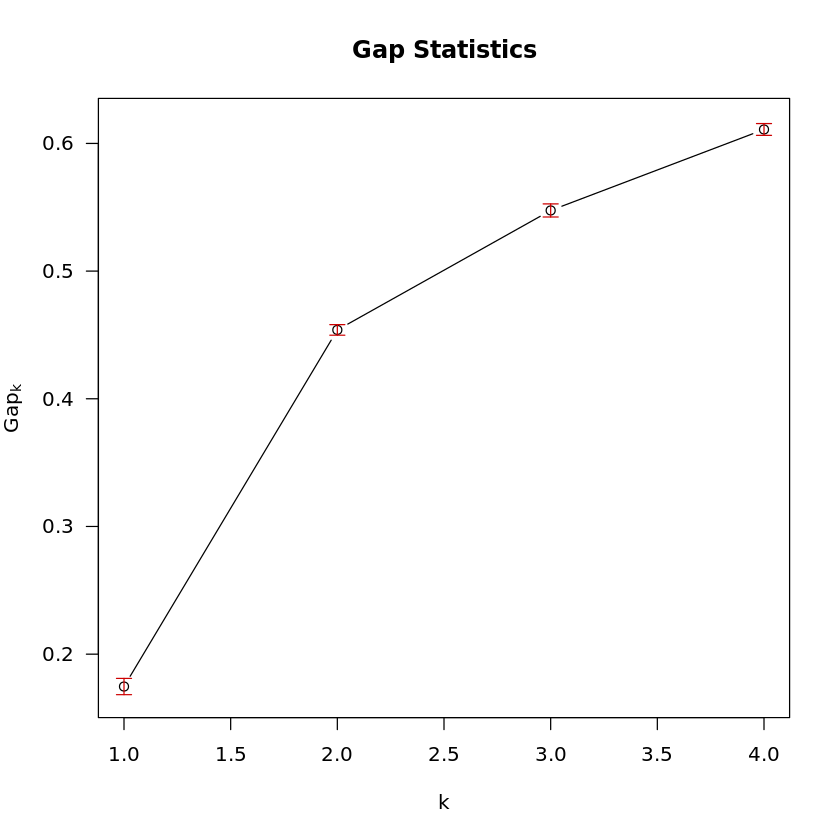

In [8]:
load("SC.RData")           # Loading the "SC" object that has include the data of the k-means clustering 
load("Ndata.RData")        # Loading the "Ndata" object and stored in the @ndata will be used to plot the expression of genes 
load("expdata.RData")      # Loading the "expdata" object and stored in the @expdata will be used to plot the expression of genes 
sc<-SC                     # Storing the data of SC in the sc 
sc@ndata<-Ndata
sc@expdata<-expdata

########## Removing the unneeded objects
rm(Ndata)
rm(expdata)
rm(DataSet)
rm(SC)
                                                    
#sc<- Clustexp(sc,cln=4,quiet=T,clustnr=6,rseed=17000)    
plotGap(sc)                                               ### Plotting gap statistics

#### 2.1.2- Evaluating the stability and consistancy of the clusters

DIscBIO enables the robustness assessment of the detected clusters in terms of stability and consistency using Jaccard’s similarity statistics and silhouette coefficients. Jaccard’s similarity index provides a comparison of members among clusters to evaluate the stability of the clusters with a range from 0% to 100%. The higher the percentage, the more stable the cluster is. Silhouette coefficients estimate how close each sample in one cluster is to samples in the neighboring clusters, reflecting the consistency of each cluster with a range of [-1, 1]. The higher the cluster mean coefficient, the more consistent the cluster is.

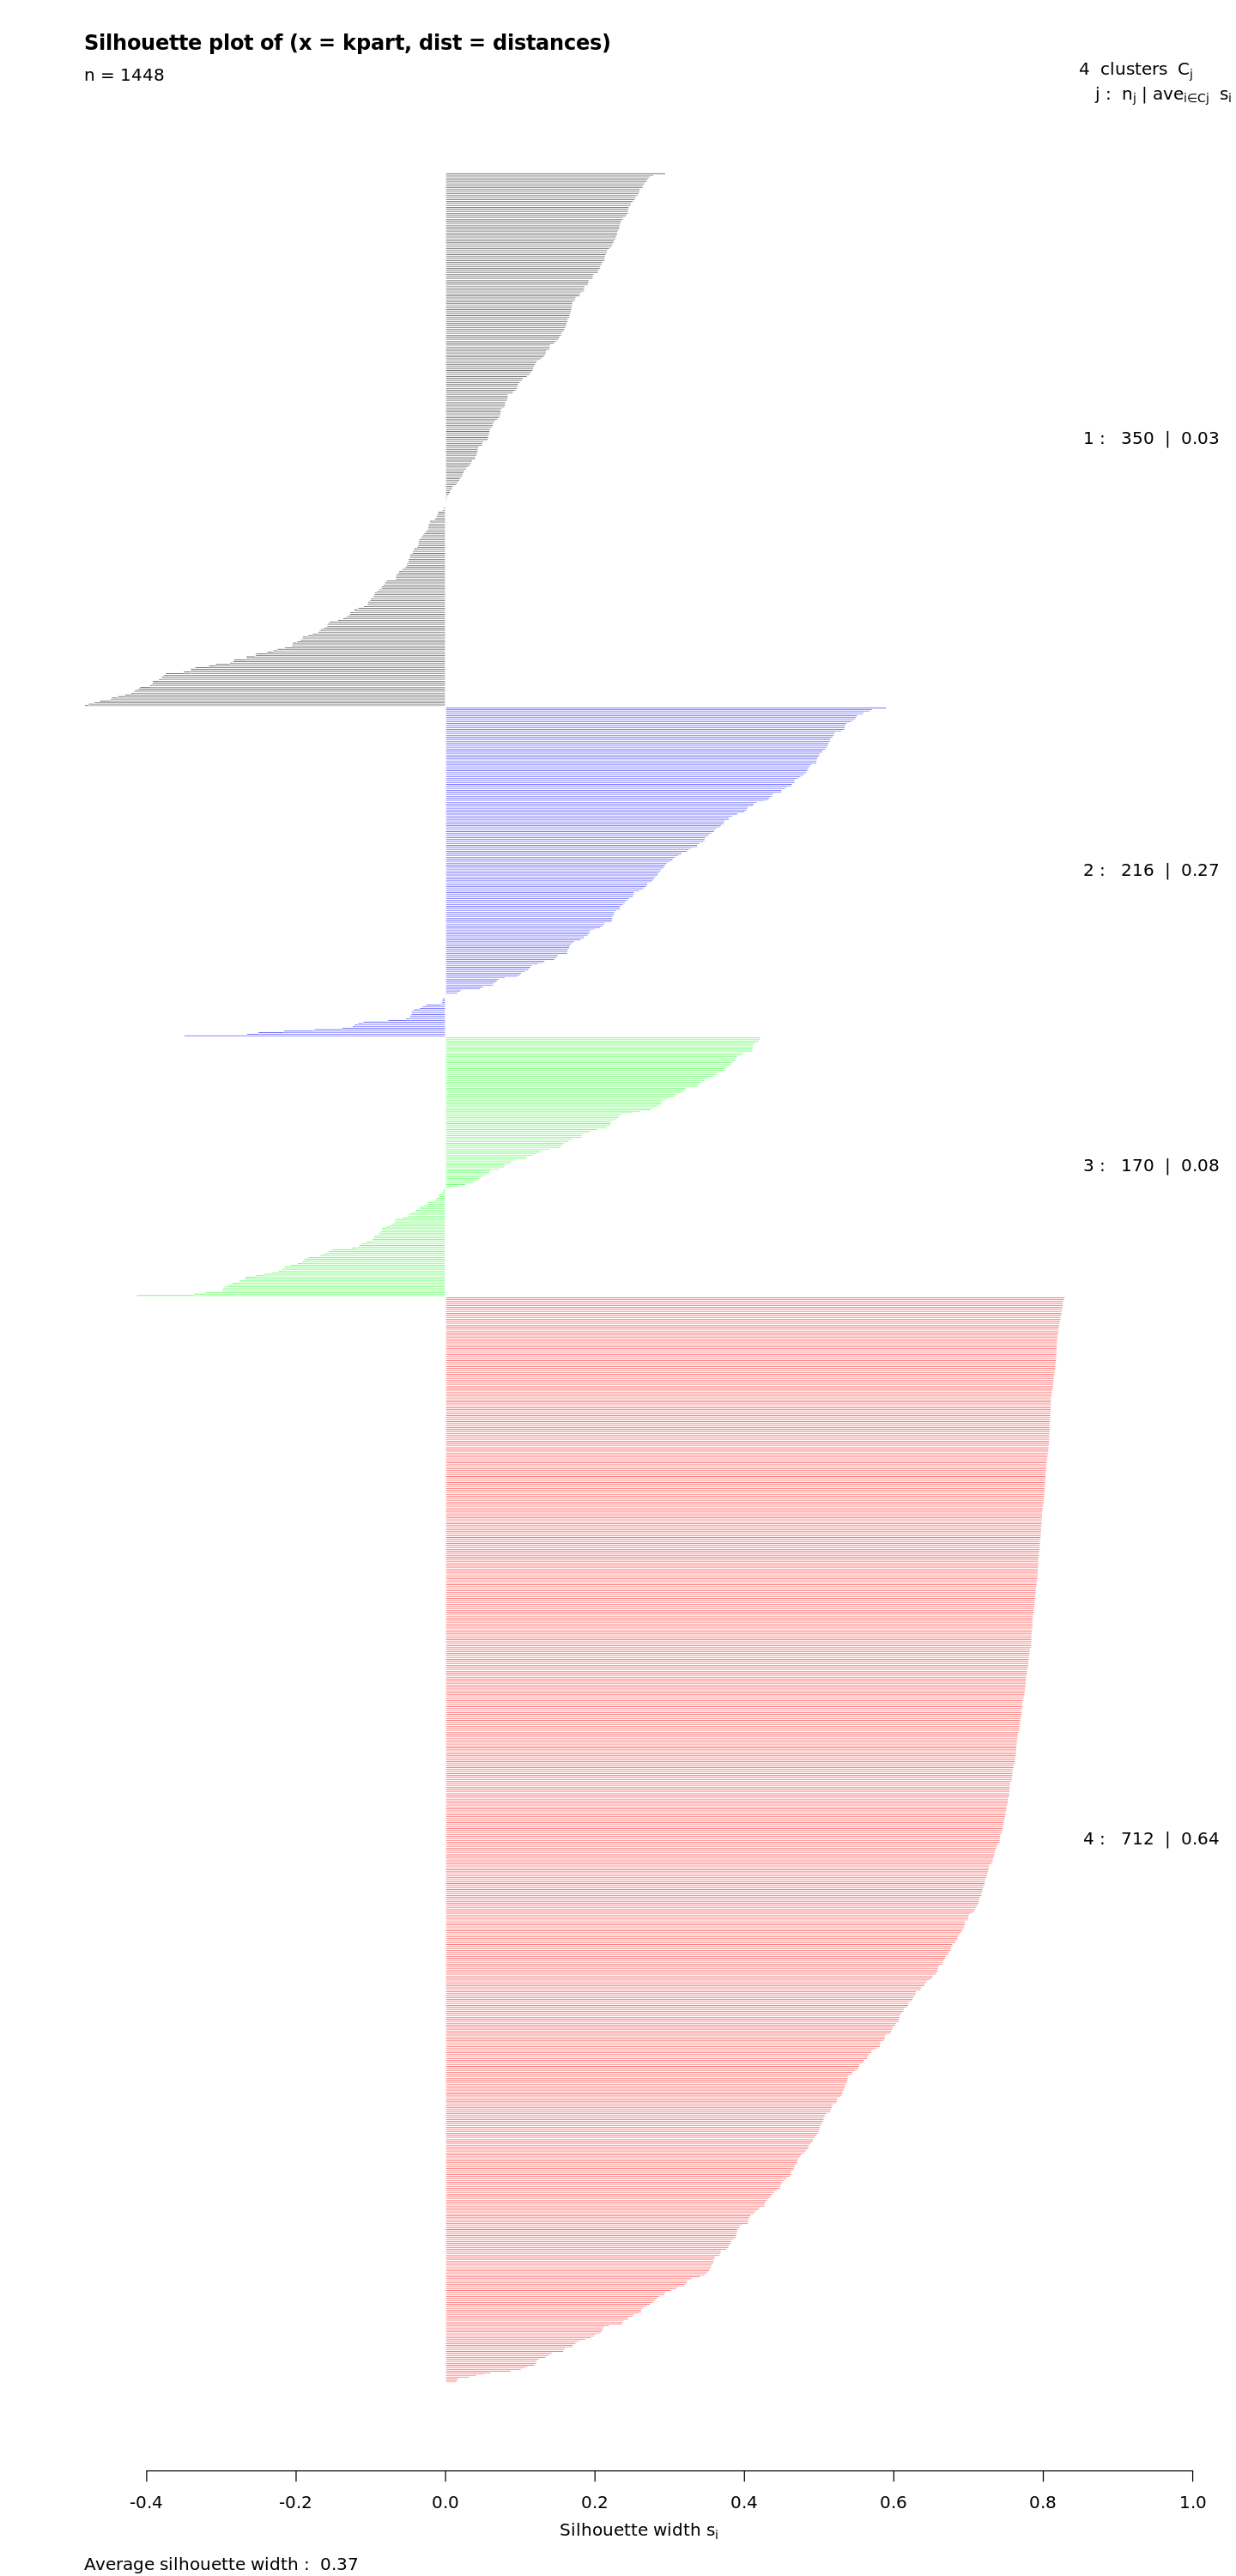

In [9]:
# Silhouette plot
options(repr.plot.width=12, repr.plot.height=25)
plotSilhouette(sc,K=4)       # K is the number of clusters

[1] 0.427 0.648 0.325 0.603

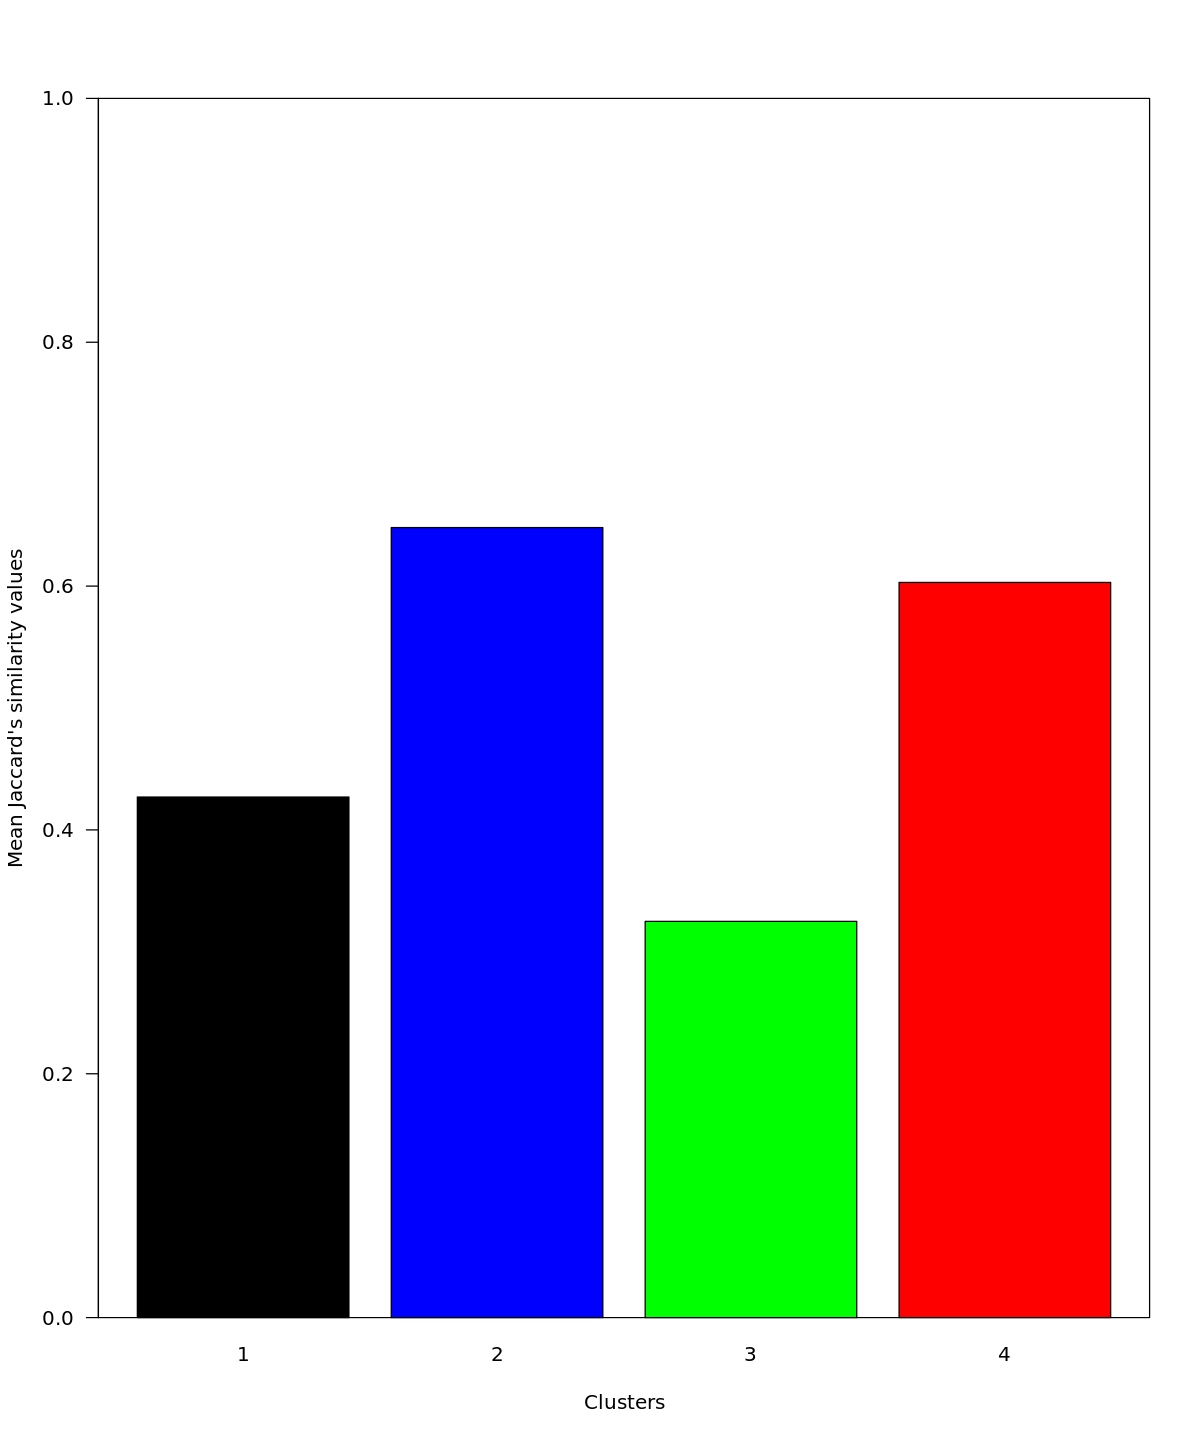

In [10]:
# Jaccard Plot
options(repr.plot.width=10, repr.plot.height=12)
Jaccard(sc,Clustering="K-means", K=4, plot = TRUE)     # Jaccard 

#### 2.1.3. Cluster plotting using tSNE maps

Here you visualize the K-means clusters using t-distributed stochastic neighbor embedding (tSNE), which is a non-linear dimensionality reduction method that places neighbor cells close to each other. 

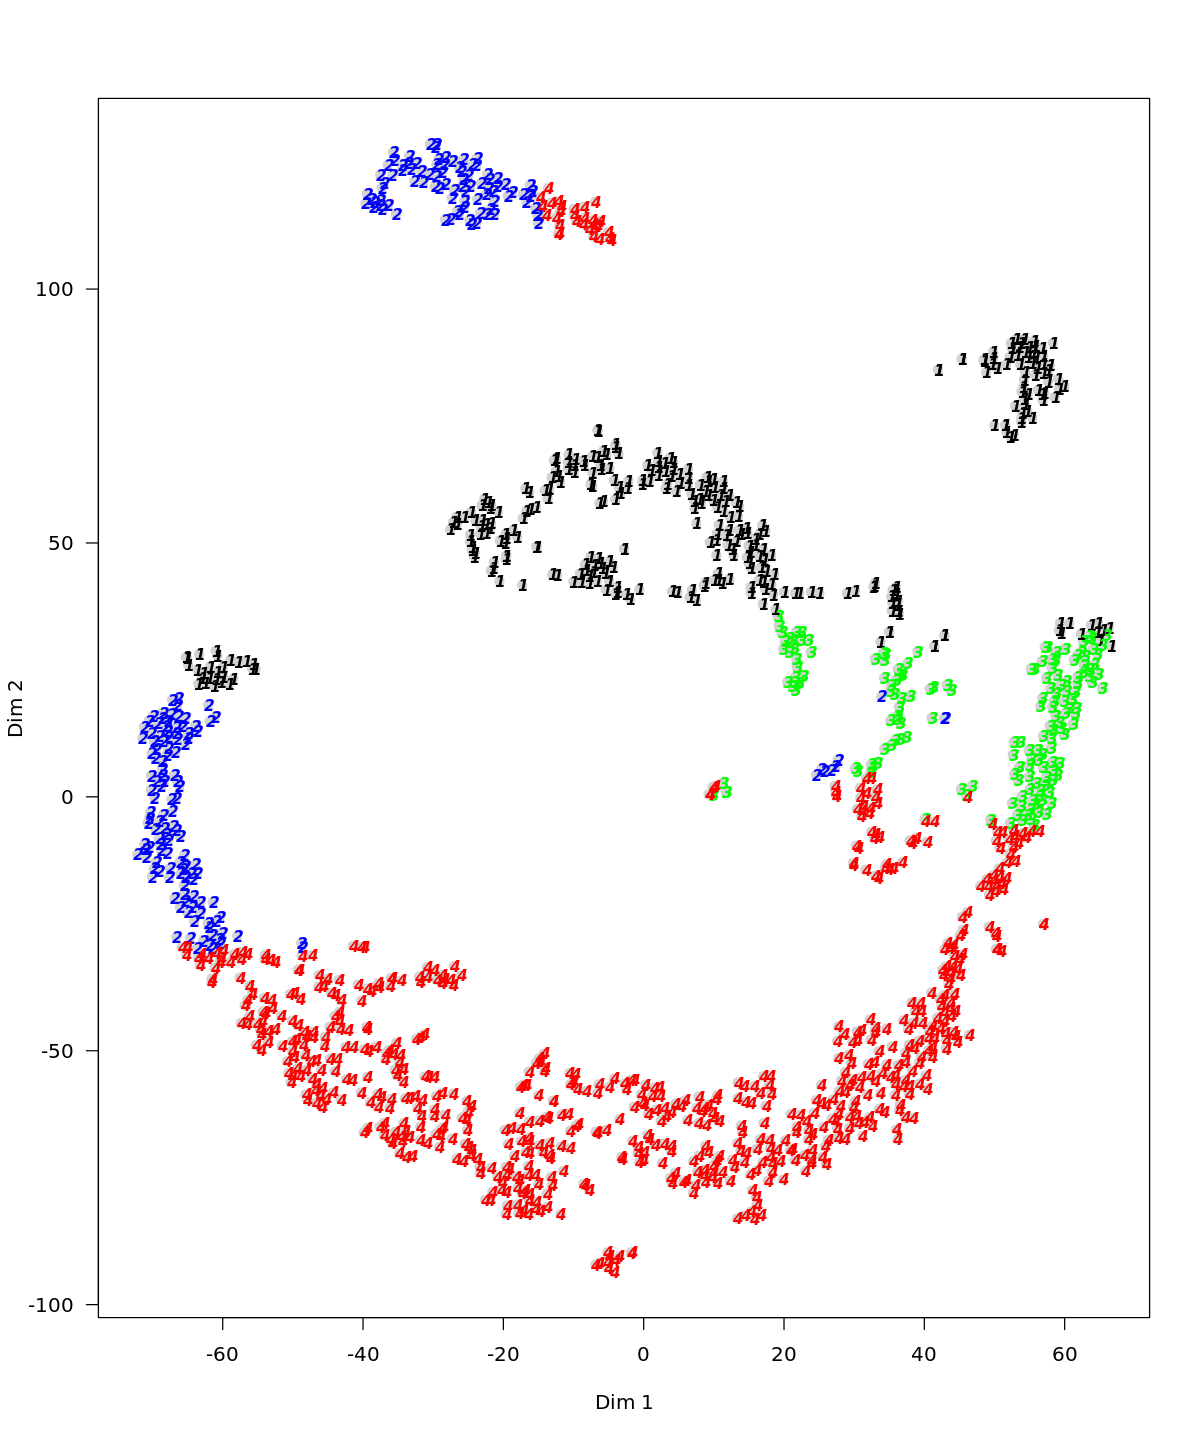

In [11]:
############ Plotting the clusters
plottSNE(sc)

#### Defining outlier cells based on K-means Clustering

Outlier identification is implemented using a background model based on distribution of transcript counts within a cluster. Outlier cells are detected if the probability for that cell c that a minimum number of genes Gmin of observing total counts TGmin is less than a specific threshold Pthr, as given by the red dotted line. Outlier cells in K-means clusters can be detected by running the FindOutliersKM() function.
 
In case the user decided to remove outlier cells, the user should set RemovingOutliers to TRUE and then start from the beginning (Data Pre-processing). 

The following cells are considered outliers: 




named integer(0)


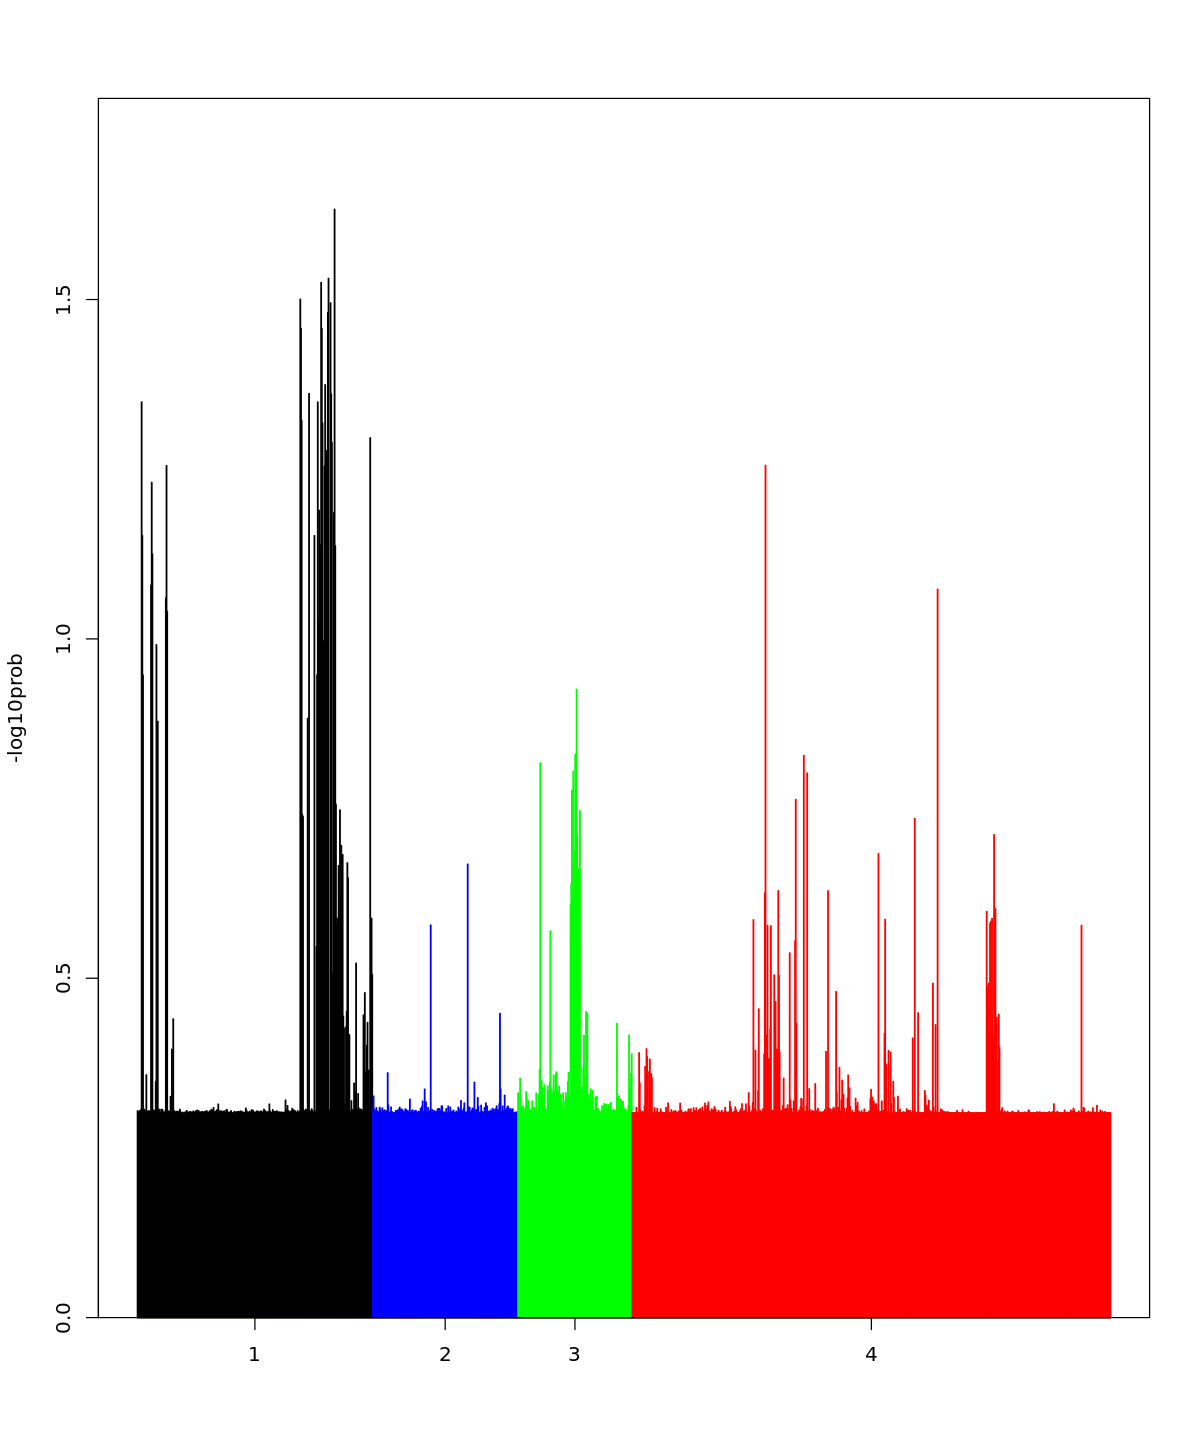

In [12]:
outlg<-round(length(sc@fdata[,1])/10)     # The cell will be considered as an outlier if it has a minimum of 10% of the number of filtered genes as outlier genes.
Outliers<- FindOutliers(sc, K=4, outminc=5,outlg=outlg,plot = TRUE, quiet = FALSE)

#### 2.1.4. Cellular pseudo-time ordering based on k-means clusters 

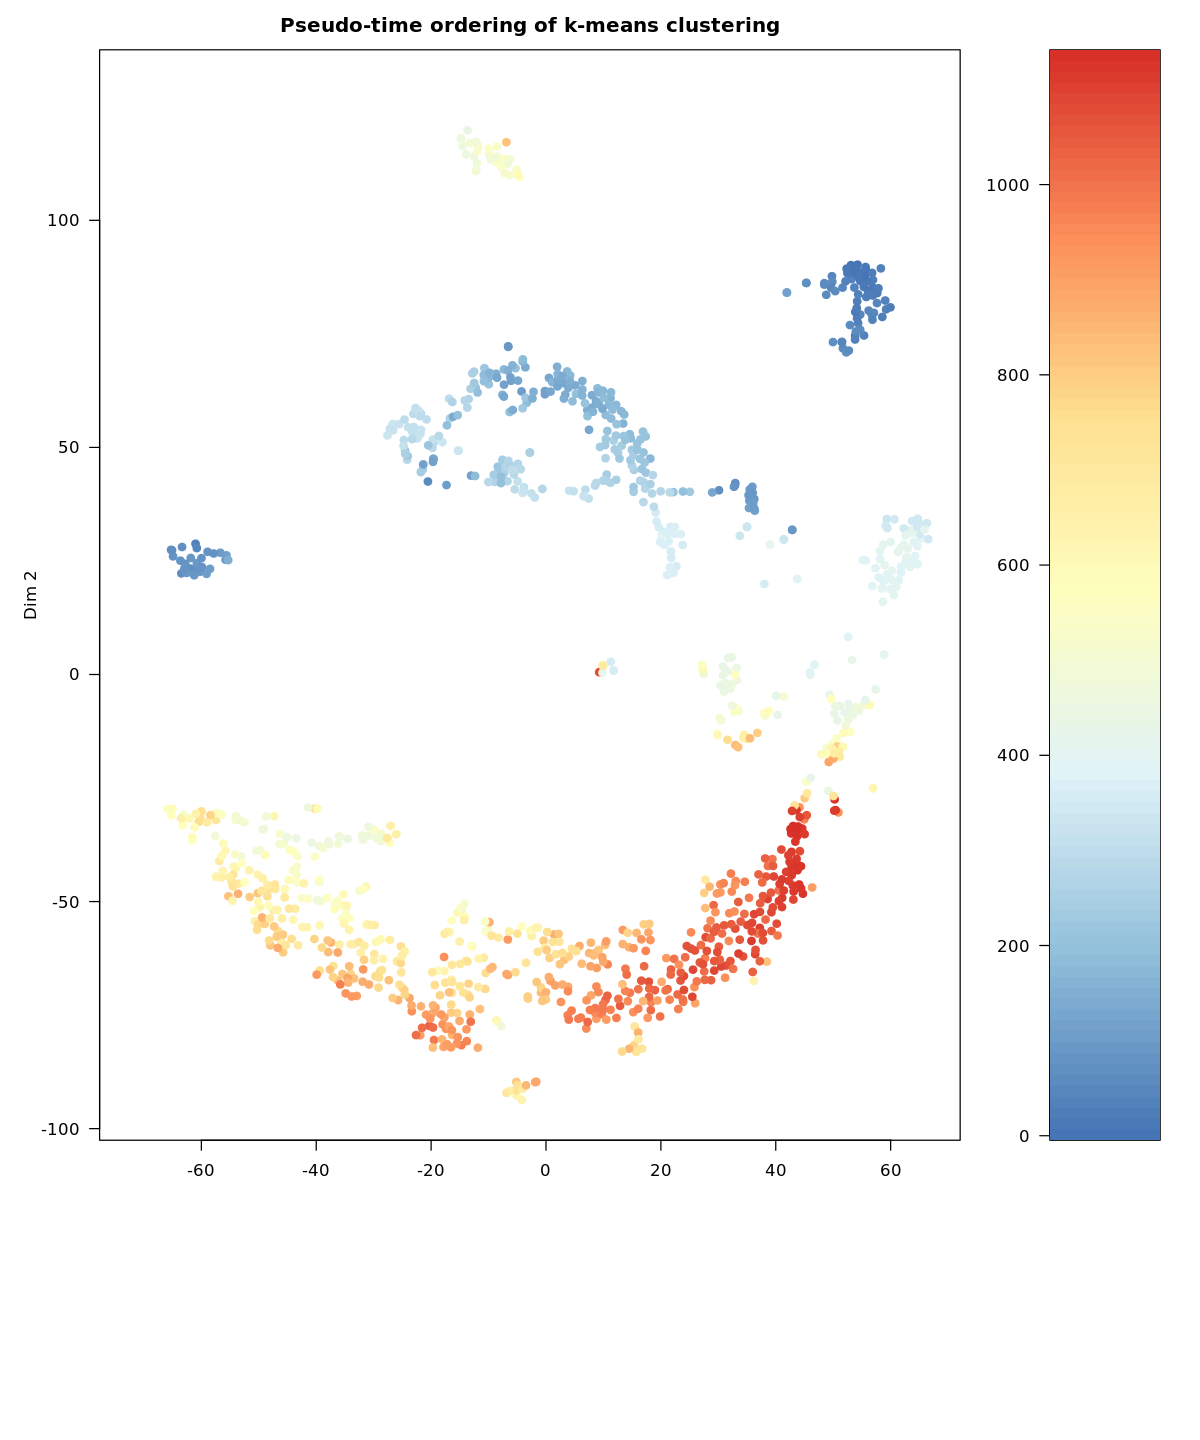

In [13]:
sc<-KmeanOrder(sc,quiet = TRUE, export = FALSE)
plotOrderTsne(sc)

#### 2.1.5 Plotting the gene expression of a particular gene in a tSNE map

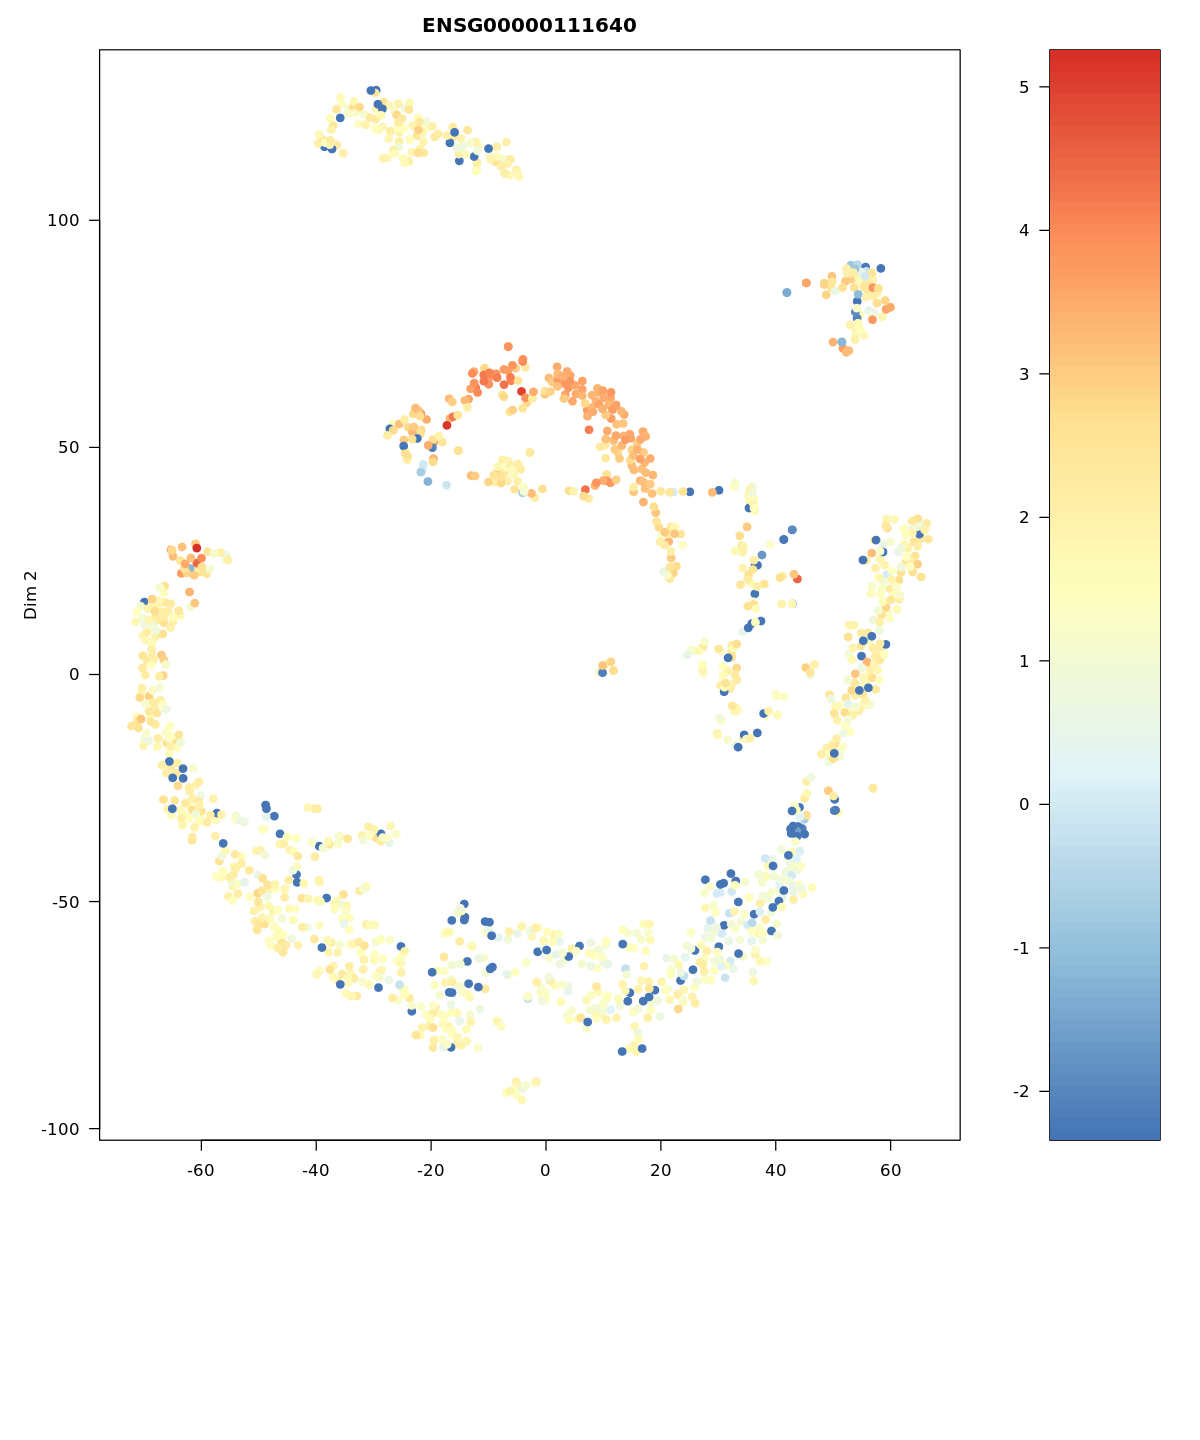

In [14]:
g='ENSG00000111640'                   #### Plotting the log expression of  GAPDH
plotExptSNE(sc,g)